Affichage de 10 exemples aléatoires sur 2975 images...


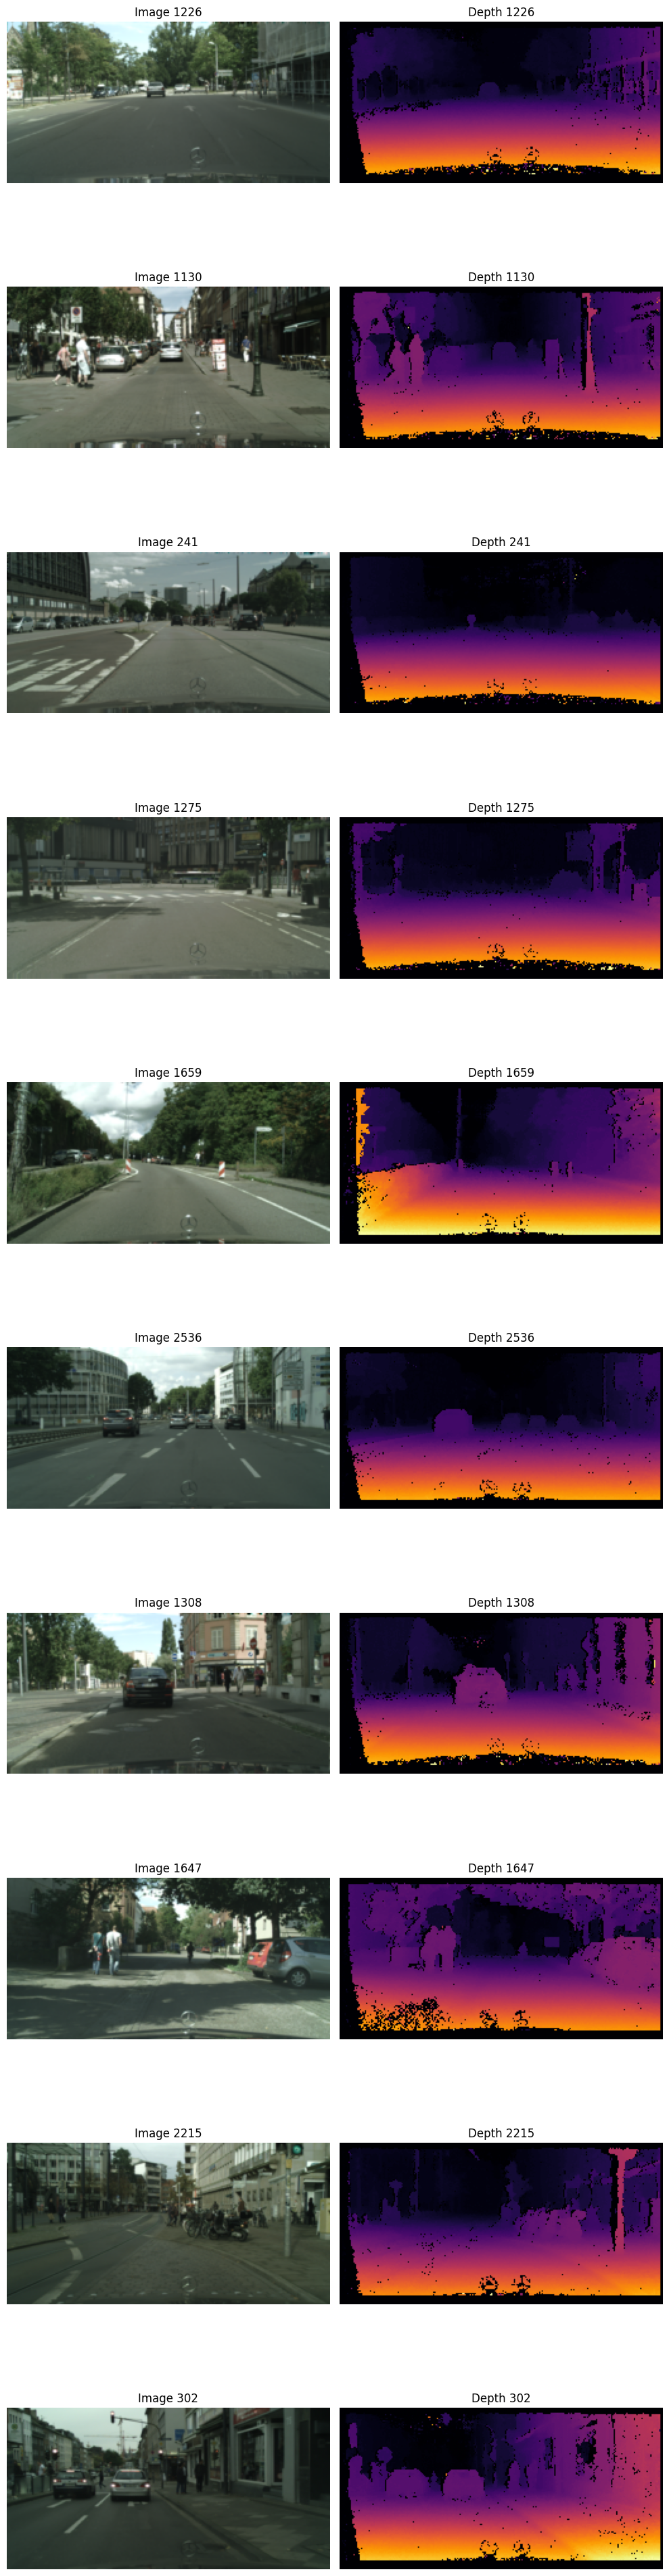

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

def visualize_samples(dataset, num_samples=10):
    # Sélectionner des indices aléatoires ou les 10 premiers
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Création de la figure (10 lignes, 2 colonnes)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, depth_tensor = dataset[idx]
        
        # --- Traitement Image RGB ---
        # Le tenseur est en format (C, H, W), Matplotlib veut (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).numpy()
        
        # --- Traitement Depth Map ---
        # Le tenseur est en (1, H, W), on enlève la dimension 1 -> (H, W)
        depth_np = depth_tensor.squeeze().numpy()
        
        # Affichage Image Originale
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Image {idx}")
        axes[i, 0].axis("off")
        
        # Affichage Depth Map
        # 'inferno' ou 'plasma' sont d'excellentes colormaps pour la profondeur
        im = axes[i, 1].imshow(depth_np, cmap='inferno') 
        axes[i, 1].set_title(f"Depth {idx}")
        axes[i, 1].axis("off")
        
        # Optionnel : barre de couleur pour voir l'échelle
        # plt.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# --- Exécution ---

# 1. On s'assure d'avoir le chemin (si vous lancez ça dans un nouveau bloc)
try:
    # Si 'dataset_path' existe déjà en mémoire, on l'utilise, sinon on le redemande
    if 'dataset_path' not in globals():
        import kagglehub
        dataset_path = kagglehub.dataset_download("sakshaymahna/cityscapes-depth-and-segmentation")
except:
    dataset_path = "votre_chemin_manuel_si_besoin"

# 2. On instancie le dataset (Assurez-vous d'avoir exécuté la définition de la classe CityscapesKaggleDataset avant)
# On utilise le split 'val' ou 'train' pour voir les images
viz_dataset = CityscapesKaggleDataset(root_dir=dataset_path, split='train', img_size=(128, 256))

print(f"Affichage de 10 exemples aléatoires sur {len(viz_dataset)} images...")
visualize_samples(viz_dataset, num_samples=10)

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import kagglehub  

# Configuration du device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f"Device utilisé : {DEVICE}")

# ==========================================
# 1. Architecture U-Net 
# ==========================================

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.dconv_down1 = DoubleConv(in_channels, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        # Decoder
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(64 + 128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        return self.conv_last(x)

# ==========================================
# 2. Dataset Adapté pour Kaggle Cityscapes
# ==========================================


class CityscapesKaggleDataset(Dataset):
    def __init__(self, root_dir, split='train', img_size=(128, 256)):
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        
        # Recherche des dossiers
        images_dir = None
        depths_dir = None
        
        for root, dirs, files in os.walk(root_dir):
            if split in root and 'image' in os.path.basename(root):
                images_dir = root
            if split in root and 'depth' in os.path.basename(root):
                depths_dir = root
        
        if not images_dir or not depths_dir:
            print(f"Erreur structure: {split}/image ou {split}/depth introuvables.")
            return

        # On récupère tous les fichiers
        self.image_files = sorted(glob.glob(os.path.join(images_dir, '*')))
        self.depth_files = sorted(glob.glob(os.path.join(depths_dir, '*')))

        # Filtrage simple pour éviter les fichiers systèmes cachés (ex: .DS_Store)
        self.image_files = [f for f in self.image_files if os.path.splitext(f)[1] in ['.jpg', '.png', '.jpeg', '.npy']]
        self.depth_files = [f for f in self.depth_files if os.path.splitext(f)[1] in ['.jpg', '.png', '.jpeg', '.npy']]

        # Alignement des tailles
        if len(self.image_files) != len(self.depth_files):
            min_len = min(len(self.image_files), len(self.depth_files))
            self.image_files = self.image_files[:min_len]
            self.depth_files = self.depth_files[:min_len]

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def _load_file(self, path, is_depth=False):
        """Fonction helper pour charger soit une image, soit un npy"""
        ext = os.path.splitext(path)[1].lower()
        
        if ext == '.npy':
            # Chargement via Numpy
            arr = np.load(path)
            
            # Gestion des dimensions (H, W, C) vs (C, H, W) vs (H, W)
            # Si l'image est en format (C, H, W), il faut la remettre en (H, W, C) pour PIL
            if len(arr.shape) == 3 and arr.shape[0] in [1, 3]: 
                 arr = np.transpose(arr, (1, 2, 0))
            
            # Normalisation pour PIL (si float entre 0 et 1 -> convertir en 0-255 uint8)
            if arr.dtype != np.uint8 and arr.max() <= 1.5: # Petite marge au cas où
                arr = (arr * 255).astype(np.uint8)
            elif arr.dtype != np.uint8:
                arr = arr.astype(np.uint8)
                
            # Si c'est une depth map en 2D (H, W), PIL attend parfois (H, W)
            if is_depth and len(arr.shape) == 3 and arr.shape[2] == 1:
                arr = arr[:, :, 0] # Squeeze le dernier canal pour faire du Grayscale pur

            mode = "L" if is_depth else "RGB"
            return Image.fromarray(arr).convert(mode)
            
        else:
            # Chargement via PIL standard
            mode = "L" if is_depth else "RGB"
            return Image.open(path).convert(mode)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        depth_path = self.depth_files[index]

        # Utilisation du loader intelligent
        try:
            image = self._load_file(img_path, is_depth=False)
            depth = self._load_file(depth_path, is_depth=True)
        except Exception as e:
            # En cas de fichier corrompu, on print et on renvoie une erreur ou on skip
            # Ici on laisse planter mais avec un message clair
            print(f"Erreur de chargement sur : {img_path} ou {depth_path}")
            raise e

        image = self.transform(image)
        depth = self.transform(depth)

        return image, depth

# ==========================================
# 3. Boucle d'Entraînement
# ==========================================

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = loader
    epoch_loss = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        
        if batch_idx % 20 == 0: # Print moins fréquent
            print(f"Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")

    return epoch_loss / len(loader)

def main():
    print("--- Téléchargement du Dataset via KaggleHub ---")
    try:
        # Télécharge le dataset et retourne le chemin local
        dataset_path = kagglehub.dataset_download("sakshaymahna/cityscapes-depth-and-segmentation")
        print(f"Dataset téléchargé ici : {dataset_path}")
    except Exception as e:
        print(f"Erreur lors du téléchargement : {e}")
        return

    # Hyperparamètres
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 8 # Réduit car Cityscapes est plus lourd que NYU
    NUM_EPOCHS = 5
    # Cityscapes est large (ex: 2048x1024). On réduit pour l'entraînement rapide du U-Net.
    IMG_HEIGHT = 128 
    IMG_WIDTH = 256
    
    # Création du Dataset et DataLoader
    # Le dataset scanne automatiquement le dossier téléchargé pour trouver 'train' -> 'image'/'depth'
    train_dataset = CityscapesKaggleDataset(
        root_dir=dataset_path, 
        split='train', 
        img_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    # Sécurité si le dataset est vide
    if len(train_dataset) == 0:
        print("Erreur : Aucune image trouvée. Vérifiez la structure du dossier téléchargé.")
        return

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY)

    print(f"Démarrage de l'entraînement avec {len(train_dataset)} images...")

    # Modèle
    model = UNet(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        avg_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        print(f"Moyenne Loss Epoch {epoch+1}: {avg_loss:.5f}")
        
        # Sauvegarde
        torch.save(model.state_dict(), "unet_cityscapes.pth")

if __name__ == "__main__":
    main()

Device utilisé : cuda
--- Téléchargement du Dataset via KaggleHub ---
Dataset téléchargé ici : C:\Users\maxim\.cache\kagglehub\datasets\sakshaymahna\cityscapes-depth-and-segmentation\versions\1
Démarrage de l'entraînement avec 2975 images...

--- Epoch 1/5 ---


C:\Users\maxim\AppData\Local\Temp\ipykernel_8492\2708935638.py:244: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\maxim\AppData\Local\Temp\ipykernel_8492\2708935638.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Batch 0/372, Loss: 0.1054
Batch 20/372, Loss: 0.0075
Batch 40/372, Loss: 0.0062
Batch 60/372, Loss: 0.0062
Batch 80/372, Loss: 0.0045
Batch 100/372, Loss: 0.0041
Batch 120/372, Loss: 0.0049
Batch 140/372, Loss: 0.0035
Batch 160/372, Loss: 0.0034
Batch 180/372, Loss: 0.0041
Batch 200/372, Loss: 0.0029
Batch 220/372, Loss: 0.0039
Batch 240/372, Loss: 0.0031
Batch 260/372, Loss: 0.0031
Batch 280/372, Loss: 0.0037
Batch 300/372, Loss: 0.0028
Batch 320/372, Loss: 0.0041
Batch 340/372, Loss: 0.0027
Batch 360/372, Loss: 0.0034
Moyenne Loss Epoch 1: 0.00529

--- Epoch 2/5 ---
Batch 0/372, Loss: 0.0029
Batch 20/372, Loss: 0.0031
Batch 40/372, Loss: 0.0031
Batch 60/372, Loss: 0.0025
Batch 80/372, Loss: 0.0019
Batch 100/372, Loss: 0.0038
Batch 120/372, Loss: 0.0021
Batch 140/372, Loss: 0.0052
Batch 160/372, Loss: 0.0041
Batch 180/372, Loss: 0.0031
Batch 200/372, Loss: 0.0028
Batch 220/372, Loss: 0.0029
Batch 240/372, Loss: 0.0023
Batch 260/372, Loss: 0.0037
Batch 280/372, Loss: 0.0029
Batch 300/3

Inférence sur : cuda
Poids du modèle chargés avec succès.


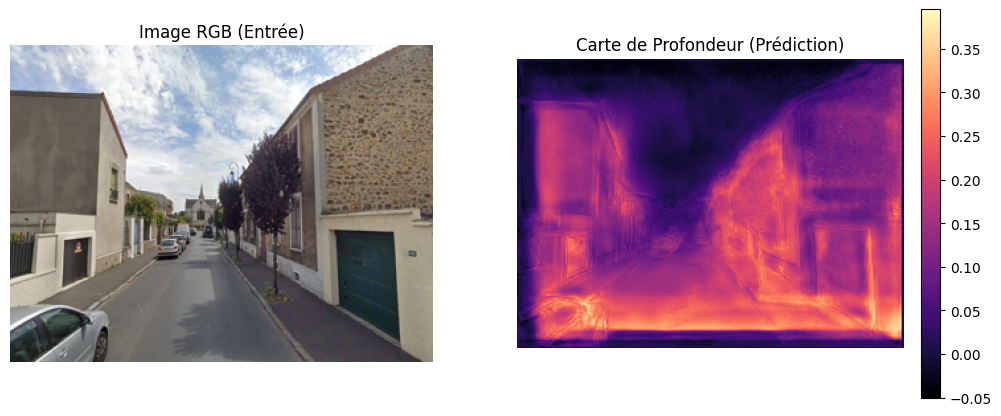

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np



def predict_depth_map(image_path, model_path, device="cuda"):
    """
    Charge le modèle, prédit la profondeur et affiche le résultat.
    """
    # 1. Configuration
    device = "cuda" if torch.cuda.is_available() and device == "cuda" else "cpu"
    print(f"Inférence sur : {device}")

    # 2. Chargement du modèle
    model = UNet(in_channels=3, out_channels=1).to(device)
    
    # Charger les poids (map_location permet de charger sur CPU si CUDA n'est pas dispo)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Poids du modèle chargés avec succès.")
    except FileNotFoundError:
        print(f"Erreur : Le fichier {model_path} est introuvable.")
        return

    model.eval() # Mode évaluation (désactive Dropout, BatchNorm fige, etc.)

    # 3. Préparation de l'image
    # IMPORTANT : On doit appliquer les mêmes transformations que lors de l'entraînement
    # Dans votre script : Resize (240, 320) + ToTensor
    original_img = Image.open(image_path).convert("RGB")
    
    preprocess = transforms.Compose([
        transforms.Resize((240, 320)), # Taille définie dans votre script d'entraînement
        transforms.ToTensor(),
    ])
    
    input_tensor = preprocess(original_img).unsqueeze(0) # Ajout de la dimension batch (1, 3, H, W)
    input_tensor = input_tensor.to(device)

    # 4. Inférence
    with torch.no_grad(): # Pas de calcul de gradient nécessaire
        output = model(input_tensor)

    # 5. Post-traitement pour l'affichage
    # On retire la dimension batch et channel (1, 1, H, W) -> (H, W)
    depth_map = output.squeeze().cpu().numpy()
    
    # 6. Affichage avec Matplotlib
    plt.figure(figsize=(12, 6))

    # Image originale (redimensionnée pour l'affichage)
    plt.subplot(1, 2, 1)
    plt.title("Image RGB (Entrée)")
    plt.imshow(original_img.resize((320, 240))) 
    plt.axis('off')

    # Carte de profondeur prédite
    plt.subplot(1, 2, 2)
    plt.title("Carte de Profondeur (Prédiction)")
    # 'magma', 'inferno' ou 'plasma' sont excellents pour visualiser la profondeur
    plt.imshow(depth_map, cmap='magma') 
    plt.axis('off')
    
    # Barre de couleur pour voir l'échelle (plus clair = plus proche ou plus loin selon l'apprentissage)
    plt.colorbar(fraction=0.046, pad=0.04) 

    plt.show()

# ==========================================
# 3. Exécution
# ==========================================

MY_IMAGE_PATH = "test_image.jpg" 

MY_MODEL_PATH = "unet_cityscapes.pth"


if __name__ == "__main__":
    import os
    if os.path.exists(MY_MODEL_PATH) and os.path.exists(MY_IMAGE_PATH):
        predict_depth_map(MY_IMAGE_PATH, MY_MODEL_PATH)
    else:
        print("Veuillez vérifier les chemins 'MY_IMAGE_PATH' et 'MY_MODEL_PATH'.")